In [1]:
from google.colab import drive
drive.mount('/content/gdrive/') 
drive.mount("/content/gdrive/", force_remount=True)

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
Mounted at /content/gdrive/


In [2]:
%cd "/content/gdrive/MyDrive/Colab Notebooks/sandwich"
%ls

/content/gdrive/MyDrive/Colab Notebooks/sandwich
 bands.csv                       firmas_espectrales_final.ipynb
 clasificador_de_frutoas.ipynb   Firmas_espectrales.ipynb
 CompositeRGBFusion.m            models/
 CubeNet_rgb2hyper.ipynb         models1/
 data/                           output/
'data (1)'/                      results/
 deblurring_dip.ipynb            results1/
 deblurring_sandwich.ipynb       results2/
 deep_denoising_barbara.ipynb    rgbTOhyper_GAN.ipynb
 degradation.mat                 RGBtoHYPER_GANs.ipynb
 degradationModelH1H2            sandwich1/
 degradationModelH3H4            Sandwich_deep_prior_Compresive_pavia.ipynb
 E2E_sandwich_pavia.ipynb        Sandwich_deep_prior.ipynb
 e2e_sandwich.py                 Sandwich_deep_prior_pavia.ipynb
 E2E_sandwich_salinas_0.ipynb    Sandwich_deep_prior_salinas.ipynb
 E2E_sandwich_salinas.ipynb      utils/


In [3]:
from __future__ import print_function
import matplotlib.pyplot as pl
from skimage.metrics import peak_signal_noise_ratio
 #os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np

import torch
import torch.optim

import scipy.io
from skimage.measure import compare_psnr
from models.downsampler import *
#from models.degradation import Spatial_blurring, spectral_blurri,gaussian
from models.resnet import ResNet
from models.unet import UNet
from models.unet_up import UNet_up
from models.unetChris import UNet_1
from models.skip import skip
from torch.nn import functional as F
from models.MAIN import *


from utils.sr_utils import *



torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

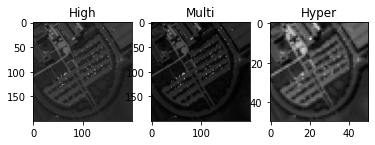

In [4]:
data_set = 'pavia'
p_factor = 4 #2  # spatial factor  # to evaluate []
q_factor = 8 #16  # Number of spectral bands
file_name  = 'data/'+data_set+'.mat'
imgs = scipy.io.loadmat(file_name)
#plot band
band = 16

HR = imgs['HR2'].transpose(2,0,1)
HR = torch.from_numpy(HR).type(dtype)
HR = HR[None, :].cuda()

# Low resolution Image

KERNEL_TYPE='lanczos2'
downsampler = Downsampler(n_planes=imgs['HR2'].shape[2], factor=p_factor, kernel_type=KERNEL_TYPE, phase=0.5, preserve_size=True).type(dtype)
img_hyper = torch.from_numpy(downsampler(HR).detach().cpu().numpy()).type(dtype)
mostr = img_hyper.detach().cpu().squeeze().numpy().transpose(1, 2, 0)
plt.subplot(1,3,1),plt.imshow(imgs['HR2'][:,:,band],cmap='gray'),plt.title('High')
plt.subplot(1,3,3),plt.imshow(mostr[:, :, band],cmap='gray'),plt.title('Hyper')

dw_spectral = spectral_blurring(Input_band=96,factor=q_factor,type='decimation')
img_LR_var = torch.from_numpy(dw_spectral(HR).detach().cpu().numpy()).type(dtype)
#mostr = img_LR_var.detach().cpu().squeeze().numpy().transpose(1, 2, 0)
mostr = img_LR_var[0].detach().cpu().numpy().transpose(1, 2, 0)
plt.subplot(1,3,2),plt.imshow(mostr[:, :, 0],cmap='gray'),plt.title('Multi')
plt.show()


img_Multi = img_LR_var

In [7]:
netH2 = UNet_1( imgs['HR2'].shape[2], img_hyper.shape[1],feature_scale=2).cuda()
netH2.load_state_dict(torch.load('/content/gdrive/MyDrive/Colab Notebooks/sandwich/degradationModelH1H2'))

<All keys matched successfully>

In [8]:
netH4 = skip(HR.shape[1],img_Multi.shape[1], 
           num_channels_down = [128]*5,
           num_channels_up =   [128]*5,
           num_channels_skip =    [4]*5,
           filter_size_up = 3,filter_size_down = 3,  filter_skip_size=1,
           upsample_mode='bilinear', # downsample_mode='avg',
           need1x1_up=False,
           need_sigmoid=False, need_bias=True, pad='reflection', act_fun='LeakyReLU').type(dtype)
netH4.load_state_dict(torch.load('/content/gdrive/MyDrive/Colab Notebooks/sandwich/degradationModelH3H4'))

<All keys matched successfully>

#Creando punto de analisis H2

In [5]:
hyper = np.zeros((imgs['HR2'].shape[0], imgs['HR2'].shape[1], imgs['HR2'].shape[2]))
hyper[100,100,:]=1.0

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


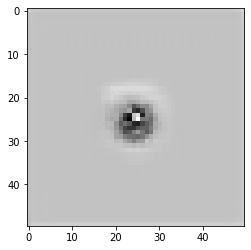

In [9]:
#modelos de degradacion pasando un punto
OUT = hyper.transpose(2,0,1)
OUT = torch.from_numpy(OUT).type(dtype)
OUT = OUT[None, :].cuda()
out_H2 = netH2(OUT) # sale hyper
OUT_npH2 = out_H2.cpu().detach().numpy()[0].transpose(1, 2, 0)
plt.imshow(OUT_npH2[:, :, band],cmap='gray')

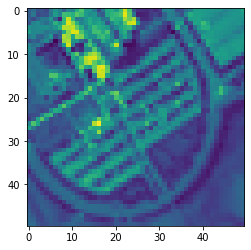

In [10]:
#modelo de degradacion pasando la imagen original
out_H2_img = netH2(HR) # sale hyper
OUT_npH2_img = out_H2_img.cpu().detach().numpy()[0].transpose(1, 2, 0)
plt.imshow(OUT_npH2_img[:, :, 9])

#Creando punto de analisis H4

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


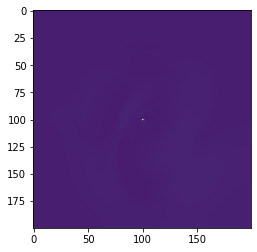

In [11]:
#modelo de degradacion pasando por un punto
multi = np.zeros((imgs['HR2'].shape[0], imgs['HR2'].shape[1], imgs['HR2'].shape[2]))
multi[100,100,:]=1.0
OUT_multi = multi.transpose(2,0,1)
OUT_multi = torch.from_numpy(OUT_multi).type(dtype)
OUT_multi = OUT_multi[None, :].cuda()
out_H4 = netH4(OUT_multi) # sale hyper
OUT_npH4 = out_H4.cpu().detach().numpy()[0].transpose(1, 2, 0)
plt.imshow(OUT_npH4[:, :, 1])

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


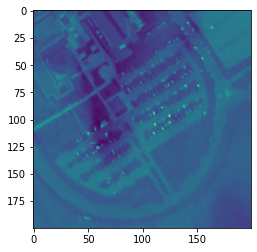

In [12]:
#modelo de degradacion pasando la imagen original
out_H4_img = netH4(HR) # sale hyper
OUT_npH4_img = out_H4_img.cpu().detach().numpy()[0].transpose(1, 2, 0)
plt.imshow(OUT_npH4_img[:, :, 1])